In [189]:
# 관련 패키지 로딩
import geopandas as gpd
import contextily as ctx
from fiona.crs import from_epsg # 좌표변환 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='Malgun Gothic') #한글 폰트 적용시   #Malgun Gothic
plt.rcParams["figure.figsize"] = (10, 10) #차트 사이즈

In [63]:
# 시도 행정구역 로딩
gdf_adm = gpd.read_file("./geodata/sido.shp", encoding='utf-8')
gdf_adm.head(10)

OBJECTID_1  OBJECTID CTPRVN_CD CTPRVN_NM    Shape_Leng    Shape_Area  \
0           1         1        42       강원도  8.533687e+05  1.654929e+10   
1           2         2        41       경기도  8.698544e+05  1.013218e+10   
2           3         3        48      경상남도  1.485298e+06  1.052046e+10   
3           4         4        47      경상북도  1.044656e+06  1.901059e+10   
4           5         5        29     광주광역시  1.221209e+05  4.979245e+08   
5           6         6        27     대구광역시  1.960206e+05  8.778580e+08   
6           7         7        30     대전광역시  1.396138e+05  5.390314e+08   
7           8         8        26     부산광역시  2.514904e+05  7.611324e+08   
8           9         9        11     서울특별시  1.573834e+05  6.047362e+08   
9          10        10        36   세종특별자치시  1.251250e+05  4.650219e+08   

  SIDO_NM2         LON        LAT  \
0       강원  128.302340  37.716453   
1       경기  127.182356  37.534578   
2       경남  128.260505  35.324084   
3       경북  128.748278  36.348621   
4       광주  126.835431  35.155718   
5       대구  128.565438  35.829510   
6       대전  127.394118  36.339949   
7       부산  129.062887  35.203427   
8       서울  126.991752  37.551902   
9       세종  127.258514  36.560713   

                                            geometry  
0  POLYGON ((1076482.353 2065382.971, 1076634.616...  
1  MULTIPOLYGON (((922590.570 1908072.190, 921838...  
2  MULTIPOLYGON (((1070191.297 1626688.504, 10710...  
3  MULTIPOLYGON (((1164310.583 1906853.577, 11647...  
4  POLYGON ((933005.068 1695846.595, 933023.961 1...  
5  POLYGON ((1107657.282 1780577.623, 1107787.941...  
6  POLYGON ((990174.453 1833170.311, 990721.121 1...  
7  MULTIPOLYGON (((1121635.972 1674227.352, 11219...  
8  POLYGON ((958513.194 1966679.499, 958561.615 1...  
9  POLYGON ((970418.371 1859456.994, 970730.575 1...

In [64]:
gdf_adm.crs

<Derived Projected CRS: PROJCS["Korea_2000_Korea_Unified_Coordinate_System ...>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [65]:
# EPSG 4326으로 좌표계 변환
gdf_adm4326 = gdf_adm.to_crs(4326)
gdf_adm3857 = gdf_adm.to_crs(3857)

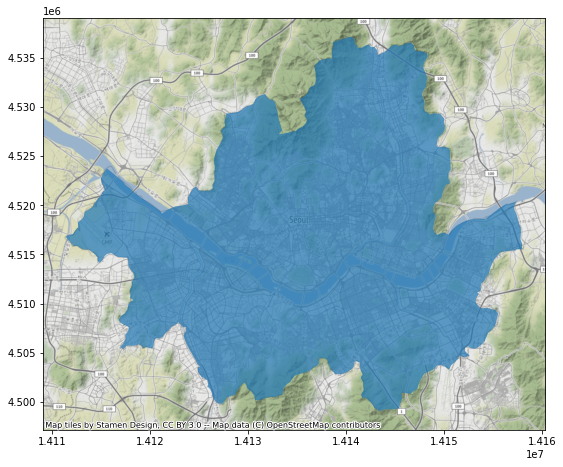

In [70]:
# 서울시 구역을 지도 위에 뿌려서 확인
ax = gdf_adm3857[8:9].plot(alpha=0.7, figsize=(9, 9))
#Include a basemap just to be sure
ctx.add_basemap(ax)

In [25]:
# Uber H3 API 패키지 로딩
import h3

In [154]:
# 서울시에 해당하는 h3 인덱스를 받음.  중간의 숫자가 h3의 레벨을 의미하고, 숫자가 커질수록 대축척
hexs = h3.polyfill(gdf_adm4326.geometry[8].__geo_interface__, 9, geo_json_conformant = True)

In [72]:
print(len(hexs))

169


In [34]:
# h3 인덱스를 폴리곤으로 변환하기 위해 Shapely 패키지 로딩
from shapely.geometry import Polygon

In [155]:
# hex id를 이용하여 폴리곤을 생성
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
# 위의 폴리곤을 가지고 지오시리즈화
hexa_polys = gpd.GeoSeries(list(map(polygonise, hexs)), index=hexs, crs="EPSG:4326")

In [156]:
#Make it a geodataframe
gdf_hexa = gpd.GeoDataFrame({"geometry": hexa_polys, "hex_id": hexa_polys.index}, crs=hexa_polys.crs)
gdf_hexa.info()
gdf_hexa.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8333 entries, 8930e1cab73ffff to 8930e1d81d7ffff
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  8333 non-null   geometry
 1   hex_id    8333 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 195.3+ KB


geometry  \
8930e1cab73ffff  POLYGON ((127.10618 37.49907, 127.10544 37.500...   
8930e1d5333ffff  POLYGON ((127.08798 37.68844, 127.08723 37.689...   
8930e1ca613ffff  POLYGON ((127.00984 37.50689, 127.00909 37.508...   
8930e1d0a7bffff  POLYGON ((127.01007 37.66809, 127.00932 37.669...   
8930e1c342fffff  POLYGON ((127.01353 37.61486, 127.01279 37.616...   

                          hex_id  
8930e1cab73ffff  8930e1cab73ffff  
8930e1d5333ffff  8930e1d5333ffff  
8930e1ca613ffff  8930e1ca613ffff  
8930e1d0a7bffff  8930e1d0a7bffff  
8930e1c342fffff  8930e1c342fffff

In [157]:
gdf_hexa.explore()

In [160]:
gdf_hexa5179 = gdf_hexa.to_crs(5179)

In [171]:
# 서울 구별 행정구역 로딩
gdf_seoul = gpd.read_file("./geodata/seoul_gu_pg.shp", encoding='utf-8')
gdf_seoul.head(2)

SIG_CD SIG_ENG_NM SIG_KOR_NM  \
0  11110  Jongno-gu        종로구   
1  11140    Jung-gu         중구   

                                            geometry  
0  POLYGON ((956615.453 1953567.199, 956621.579 1...  
1  POLYGON ((957890.386 1952616.746, 957909.908 1...

In [173]:
# 헥사곤과 서울시 구를 공간조인
gdf_hexa2 = gpd.sjoin(gdf_hexa5179, gdf_seoul, how='inner', predicate='within')
gdf_hexa2.head()

C:\Users\User\AppData\Local\Temp\ipykernel_28748\44034649.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5179
Right CRS: PROJCS["Korea_2000_Korea_Unified_Coordinate_System ...

  gdf_hexa2 = gpd.sjoin(gdf_hexa5179, gdf_seoul, how='inner', predicate='within')


geometry  \
8930e1cab73ffff  POLYGON ((965190.105 1944495.936, 965124.836 1...   
8930e1c88a7ffff  POLYGON ((966890.954 1942317.123, 966825.668 1...   
8930e1cf623ffff  POLYGON ((967377.675 1945884.823, 967312.381 1...   
8930e1c1a4fffff  POLYGON ((965240.209 1948451.165, 965174.936 1...   
8930e1c88b7ffff  POLYGON ((966672.729 1942511.148, 966607.445 1...   

                          hex_id  index_right SIG_CD SIG_ENG_NM SIG_KOR_NM  
8930e1cab73ffff  8930e1cab73ffff           23  11710  Songpa-gu        송파구  
8930e1c88a7ffff  8930e1c88a7ffff           23  11710  Songpa-gu        송파구  
8930e1cf623ffff  8930e1cf623ffff           23  11710  Songpa-gu        송파구  
8930e1c1a4fffff  8930e1c1a4fffff           23  11710  Songpa-gu        송파구  
8930e1c88b7ffff  8930e1c88b7ffff           23  11710  Songpa-gu        송파구

<AxesSubplot:>

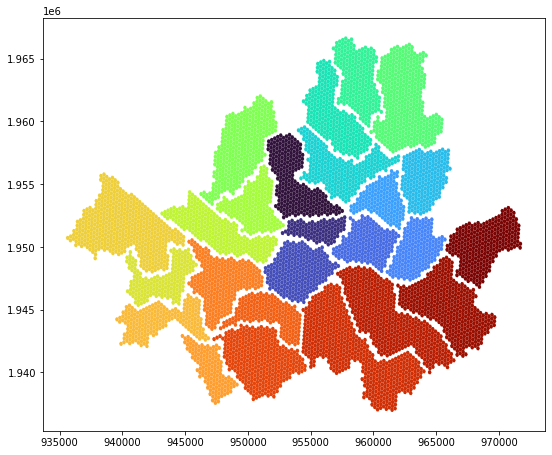

In [174]:
gdf_hexa2.plot('SIG_CD', categorical=True, figsize=(9,9), cmap='turbo')  #gist_rainbow, turbo

In [175]:
# 구별로 Dissolve
gdf_hexa_d = gdf_hexa2.dissolve(by='SIG_CD')
gdf_hexa_d.head()

geometry           hex_id  \
SIG_CD                                                                       
11110   POLYGON ((952155.480 1953421.423, 952307.989 1...  8930e1daa87ffff   
11140   POLYGON ((953590.175 1950813.867, 953525.028 1...  8930e1d8943ffff   
11170   POLYGON ((952123.796 1946459.938, 952058.668 1...  8930e1d9d13ffff   
11200   POLYGON ((957839.343 1948699.752, 957774.151 1...  8930e1c1637ffff   
11215   POLYGON ((961853.373 1947573.533, 961700.578 1...  8930e1cac83ffff   

        index_right    SIG_ENG_NM SIG_KOR_NM  
SIG_CD                                        
11110             0     Jongno-gu        종로구  
11140             1       Jung-gu         중구  
11170             2    Yongsan-gu        용산구  
11200             3  Seongdong-gu        성동구  
11215             4   Gwangjin-gu        광진구

In [220]:
gdf_hexa_d3857 = gdf_hexa_d.to_crs(3857)
gdf_hexa_d4326 = gdf_hexa_d.to_crs(4326)

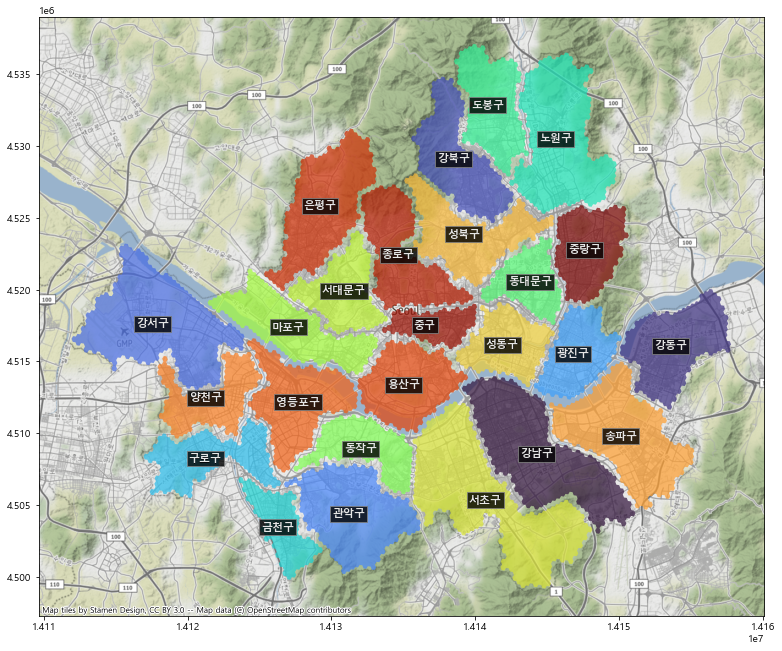

In [243]:
ax = gdf_hexa_d3857.plot('SIG_KOR_NM',categorical=True, figsize=(13,13), alpha=0.7, cmap='turbo') #gist_rainbow

for idx, row in gdf_hexa_d3857.iterrows():   
    plt.text(row.geometry.centroid.x - 1450, row.geometry.centroid.y - 200, row['SIG_KOR_NM'], fontsize=11, bbox={'facecolor': 'black', 'alpha':0.8, 'pad': 2, 'edgecolor':'gray'})
    plt.text(row.geometry.centroid.x - 1450, row.geometry.centroid.y - 200, row['SIG_KOR_NM'], fontsize=11, color='white', alpha=0.9 , fontweight='bold')

ctx.add_basemap(ax=ax)

fig = plt.gcf()
#plt.show()
#plt.savefig("./geodata/seoul_gu_cartogram.png", dpi=150, bbox_inches='tight', pad_inches=0)

In [239]:
gdf_hexa_d4326.explore('SIG_KOR_NM',categorical=True, tiles='http://xdworld.vworld.kr:8080/2d/Satellite/service/{z}/{x}/{y}.jpeg', attr='브이월드')

In [240]:
# shp 저장
gdf_hexa_d.to_file("./geodata//seoul_hexa.shp", encoding='utf-8')

C:\Users\User\AppData\Local\Temp\ipykernel_28748\2344061371.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hexa_d.to_file("./geodata//seoul_hexa.shp", encoding='utf-8')
